<a href="https://colab.research.google.com/github/wannasmile/colab_code_note/blob/main/IRC009.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/wannasmile/colab_code_note/refs/heads/main/tra_sample.xlsx

--2025-02-07 16:15:39--  https://raw.githubusercontent.com/wannasmile/colab_code_note/refs/heads/main/tra_sample.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2666118 (2.5M) [application/octet-stream]
Saving to: ‘tra_sample.xlsx.8’

tra_sample.xlsx.8   100%[===================>]   2.54M  --.-KB/s    in 0.06s   

2025-02-07 16:15:39 (45.8 MB/s) - ‘tra_sample.xlsx.8’ saved [2666118/2666118]



In [2]:
import pandas as pd
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import numpy as np
import random
import math
from sklearn.calibration import CalibratedClassifierCV
data = pd.read_excel('tra_sample.xlsx')
data.head()
feature_lst = ['zx_score','msg_cnt','phone_num_cnt','register_days']
train = data[data.type == 'target'].reset_index().copy() #目标域
diff = data[data.type == 'origin'].reset_index().copy() #源域
val = data[data.type == 'offtime'].reset_index().copy()

In [3]:
data.head()

,zx_score,msg_cnt,phone_num_cnt,register_days,bad_ind,type
0,-0.322581,0.023810,0.00,0.217949,0,target
1,0.078853,0.023810,0.02,0.461538,0,target
2,0.078853,0.071429,0.00,0.217949,0,target
3,-0.128677,0.023810,0.00,0.217949,0,target
4,-0.261014,0.071429,0.05,0.217949,0,target


In [4]:

'''
TrainT 目标域样本
TrainS 源域样本
LabelT 目标域标签
LabelS 源域标签
'''

train = train.loc[:1200]

trans_T = train[feature_lst].copy()
label_T = train['bad_ind'].copy()

trans_S = diff[feature_lst].copy()
label_S = diff['bad_ind'].copy()

val_x = val[feature_lst].copy()
val_y = val['bad_ind'].copy()

test = val_x.copy()


train_ks :  0.48500238435860754
val_ks :  0.3887057754389137


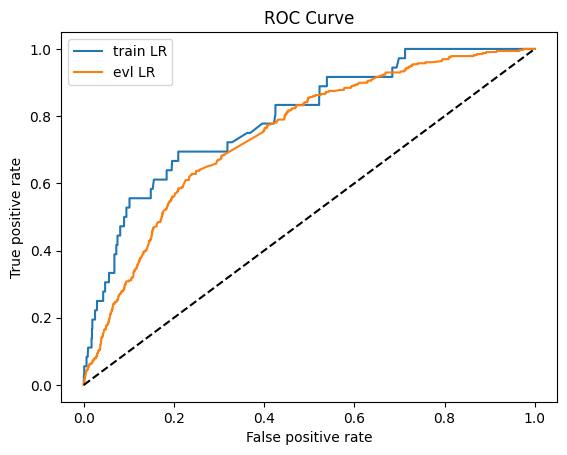

In [5]:

"""
只对目标域样本拟合
"""
lr_model = LogisticRegression(C=0.1, class_weight='balanced', solver='liblinear')
lr_model.fit(trans_T, label_T)

y_pred = lr_model.predict_proba(trans_T)[:,1]
fpr_lr_train,tpr_lr_train,_ = roc_curve(label_T,y_pred)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ',train_ks)

y_pred = lr_model.predict_proba(test)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)
val_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ',val_ks)

from matplotlib import pyplot as plt
plt.plot(fpr_lr_train, tpr_lr_train, label = 'train LR')
plt.plot(fpr_lr, tpr_lr, label = 'evl LR')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


train_ks :  0.4910909493184976
val_ks :  0.33077621830414


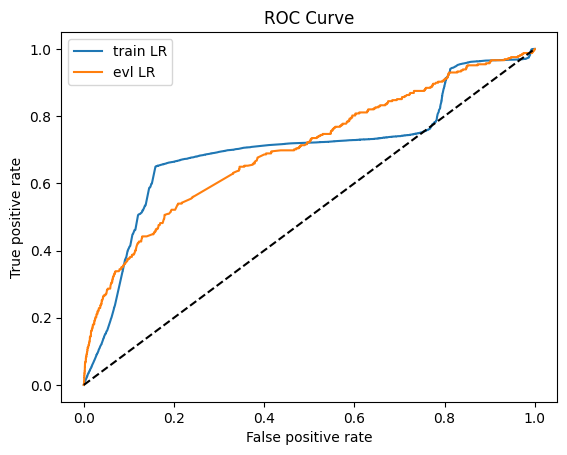

In [6]:
"""
对源域和目标域样本混合后直接拟合
"""
trans_data = np.concatenate((trans_T, trans_S), axis=0)
trans_label = np.concatenate((label_T, label_S), axis=0)

lr_model = LogisticRegression(C=0.3, class_weight='balanced', solver='liblinear')
lr_model.fit(trans_S, label_S)

y_pred = lr_model.predict_proba(trans_data)[:,1]
fpr_lr_train,tpr_lr_train,_ = roc_curve(trans_label,y_pred)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ',train_ks)

y_pred = lr_model.predict_proba(test)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)
val_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ',val_ks)

from matplotlib import pyplot as plt
plt.plot(fpr_lr_train, tpr_lr_train, label = 'train LR')
plt.plot(fpr_lr, tpr_lr, label = 'evl LR')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()


什么是 JDA？

JDA 是一种迁移学习算法，旨在解决源域和目标域数据分布差异的问题。简单来说，它就是想办法让源域和目标域的数据分布更接近，从而使在源域上训练的模型也能在目标域上取得良好的性能。

举个例子

假设我们要训练一个模型来识别猫和狗的图片。我们有大量的标注好的猫狗图片数据集（源域），但我们想把这个模型应用到另一个数据集上，比如卡通猫狗图片数据集（目标域）。

问题是：真实猫狗图片和卡通猫狗图片的分布是不同的。直接将源域训练的模型应用到目标域上，效果可能很差。

这时 JDA 就派上用场了！它会尝试将真实猫狗图片的分布和卡通猫狗图片的分布进行对齐，让它们更接近。这样，在源域上训练的模型就能更好地适应目标域，提高识别准确率。

JDA 的原理

JDA 的核心思想是联合分布适配，即同时对齐源域和目标域的边缘分布和条件分布。

* 边缘分布：指数据的整体分布，比如真实猫狗图片和卡通猫狗图片各自的特征分布。
* 条件分布：指在给定类别标签下，数据的分布，比如真实猫狗图片中，猫和狗各自的特征分布。

JDA 通过最小化源域和目标域之间的边缘分布差异和条件分布差异来实现分布对齐。

简单的比喻

想象一下，有两个水池，分别代表源域和目标域。每个水池里都有一些不同颜色的球，代表不同类别的数据。

* 边缘分布对齐：就是调整两个水池的水位，让它们的水位相同。
* 条件分布对齐：就是调整每个水池里不同颜色球的数量比例，让它们相同。

JDA 的目标就是让两个水池的水位和球的比例都相同，这样两个水池里的球的分布就基本一致了。

JDA 的优势

* 能够同时对齐边缘分布和条件分布，更全面地解决分布差异问题。
* 不需要目标域的标签，可以用于无监督迁移学习。

JDA 的局限性

* 计算复杂度较高，尤其是在数据量很大的情况下。
* 需要选择合适的核函数和参数。

总结

JDA 是一种有效的迁移学习算法，可以帮助我们解决源域和目标域数据分布差异的问题。通过联合分布适配，JDA 能够提高模型在目标域上的泛化能力。


边缘分布 (Marginal Distribution)

想象一下，你有一个装满红色和蓝色球的袋子。边缘分布关注的是：
* 袋子里有多少个红球？
* 袋子里有多少个蓝球？
它不关心红球和蓝球之间的任何关系，只关注每种颜色球的整体数量或比例。

在机器学习中，特征就是这些球的颜色，而边缘分布就是每个特征在整个数据集中出现的频率或概率。

例如，在猫狗图片数据集中，边缘分布描述了：
* 所有图片中，有多少图片包含尖耳朵的特征？
* 所有图片中，有多少图片包含毛茸茸尾巴的特征？
它不关心尖耳朵和毛茸茸尾巴是否同时出现在一张图片中，只关心它们各自出现的频率。

条件分布 (Conditional Distribution)

现在，我们仍然用装满红色和蓝色球的袋子来举例。条件分布关注的是：
* 在已知某个球是红色的情况下，它是大球的概率是多少？
* 在已知某个球是蓝色的情况下，它是小球的概率是多少？
它关心在给定某个条件（比如球的颜色）下，另一个特征（比如球的大小）的分布情况。

在机器学习中，条件分布描述了在给定类别标签下，每个特征的分布情况。

例如，在猫狗图片数据集中，条件分布描述了：
* 在所有猫的图片中，有多少图片包含尖耳朵的特征？
* 在所有狗的图片中，有多少图片包含毛茸茸尾巴的特征？
它关心在给定类别标签（猫或狗）下，特定特征（尖耳朵或毛茸茸尾巴）出现的频率。

简单总结
* 边缘分布：描述每个特征在整个数据集中的整体分布情况。
* 条件分布：描述在给定类别标签下，每个特征的分布情况。

回到 JDA

JDA 算法的目标是使源域和目标域的边缘分布和条件分布都尽可能接近。

这意味着：

* 源域和目标域中，每个特征出现的频率应该相似（边缘分布对齐）。
* 在给定类别标签下，源域和目标域中，每个特征出现的频率也应该相似（条件分布对齐）。

通过对齐边缘分布和条件分布，JDA 算法可以减少源域和目标域之间的差异，从而提高模型在目标域上的性能。

更形象的比喻

* 边缘分布：就像统计一个班级里男生和女生的人数比例。
* 条件分布：就像统计班级里，戴眼镜的男生和戴眼镜的女生的人数比例。

联合分布适配（Joint Distribution Adaptation, JDA）是迁移学习中一种经典的领域自适应方法，其核心思想是通过**同时对齐源域和目标域的边缘分布和条件分布**，从而减少领域间的分布差异。以下是其数学原理的层次化解析：

---

### 一、问题定义
给定：
- **源域**数据 $ X_s \in \mathbb{R}^{d \times n_s} $（$ d $ 维特征，$ n_s $ 个样本）和标签 $ Y_s $
- **目标域**数据 $ X_t \in \mathbb{R}^{d \times n_t} $（无标签或部分伪标签 $ Y_t $）

目标：  
学习一个**特征变换矩阵** $ A \in \mathbb{R}^{d \times k} $，使得变换后的特征 $ Z = A^\top X $ 满足：
1. 保持数据的主要统计特性
2. 最小化源域和目标域的**联合分布差异**（边缘分布 + 条件分布）

---

### 二、核心数学工具
#### 1. 最大均值差异（MMD）
用于度量两个分布之间的差异，定义为再生核希尔伯特空间（RKHS）中均值嵌入的距离：
$$
\text{MMD}^2 = \left\| \frac{1}{n_s} \sum_{i=1}^{n_s} \phi(x_s^i) - \frac{1}{n_t} \sum_{j=1}^{n_t} \phi(x_t^j) \right\|_{\mathcal{H}}^2
$$
其中 $ \phi(\cdot) $ 是核映射函数。

#### 2. 中心矩阵（Centering Matrix）
用于数据去均值化：
$$
H = I_{n} - \frac{1}{n} \mathbf{1}\mathbf{1}^\top \quad (n = n_s + n_t)
$$

---

### 三、JDA的优化目标
JDA通过以下三个步骤构建目标函数：

#### 1. 边缘分布适配（Marginal Distribution Adaptation）
最小化源域和目标域**整体分布**的差异：
$$
\min_A \text{tr}(A^\top X M_0 X^\top A)
$$
其中 $ M_0 $ 是边缘MMD矩阵，定义为：
$$
(M_0)_{ij} = \begin{cases}
\frac{1}{n_s^2} & x_i, x_j \in X_s \\
\frac{1}{n_t^2} & x_i, x_j \in X_t \\
-\frac{1}{n_s n_t} & \text{otherwise}
\end{cases}
$$

#### 2. 条件分布适配（Conditional Distribution Adaptation）
最小化**类别条件分布**的差异。对于每个类别 $ c \in \{1,...,C\} $，构造条件MMD矩阵 $ M_c $，目标函数为：
$$
\min_A \sum_{c=1}^C \text{tr}(A^\top X M_c X^\top A)
$$

#### 3. 联合优化目标
将边缘分布和条件分布适配联合优化：
$$
\min_A \sum_{c=0}^C \text{tr}(A^\top X M_c X^\top A) + \lambda \|A\|_F^2
$$
其中 $ \lambda $ 是正则化参数，$ M_0 $ 对应边缘分布，$ M_1,...,M_C $ 对应条件分布。

---

### 四、广义特征值分解
通过引入中心矩阵 $ H $ 保持数据方差（类似PCA），将问题转化为广义特征值问题：
$$
X \left( \sum_{c=0}^C M_c \right) X^\top A = \lambda X H X^\top A
$$
求解前 $ k $ 个最小特征值对应的特征向量，即为最优变换矩阵 $ A $。

---

### 五、算法流程
1. **数据预处理**：标准化数据，构建联合数据矩阵 $ X = [X_s, X_t] $
2. **构造MMD矩阵**：计算边缘分布 $ M_0 $ 和条件分布 $ M_1,...,M_C $
3. **中心化数据**：通过 $ H $ 矩阵去均值
4. **求解特征分解**：获得变换矩阵 $ A $
5. **特征投影**：得到适配后的特征 $ Z = A^\top X $

---

### 六、与其他方法的对比
| 方法 | 适配对象 | 核心思想 |
|-------|---------|---------|
| TCA   | 边缘分布 | 只对齐整体分布 |
| CORAL | 协方差矩阵 | 对齐二阶统计量 |
| JDA   | **联合分布** | 同时对齐边缘和条件分布 |
| DAN   | 深度特征 | 通过深度网络多层适配 |

---

### 七、关键特性
- **双重适配机制**：同时减少边缘分布和条件分布的差异
- **伪标签策略**：通过迭代优化目标域伪标签提升条件分布估计
- **核技巧扩展**：可通过核方法处理非线性问题
- **计算复杂度**：$ O((n_s+n_t)^3) $，适合中等规模数据

---

### 八、应用场景
- 跨领域图像分类（如MNIST → USPS数字识别）
- 自然语言处理中的跨领域情感分析
- 医学图像分析中的跨设备数据适配
- 任何存在领域偏移但任务相似的应用场景

通过这种数学框架，JDA能够显著提升目标域任务的性能，尤其在源域和目标域分布差异较大但类别语义一致的情况下表现突出。

In [7]:
import numpy as np
from scipy.linalg import norm
from scipy.sparse.linalg import eigs

def JDA(Xs, Xt, Ys, Yt, k=100, lamda=0.1, ker='primal', gamma=1.0, data='default'):
    """
    Performs Joint Distribution Adaptation (JDA) with improved input handling.

    Args:
        Xs: Source domain data (features x samples). Accepts DataFrame or numpy array.
        Xt: Target domain data (features x samples). Accepts DataFrame or numpy array.
        Ys: Source domain labels (1D array-like).
        Yt: Target domain labels (1D array-like).
        k: Number of principal components.
        lamda: Regularization parameter.
        ker: Kernel type ('primal' or 'linear').
        gamma: Kernel parameter.
        data: Data type ('default' or other).

    Returns:
        A: Transformation matrix.
        Z: Transformed data.
    """

    # Convert DataFrames to numpy arrays without transposing
    if hasattr(Xs, 'to_numpy'): Xs = Xs.to_numpy()
    if hasattr(Xt, 'to_numpy'): Xt = Xt.to_numpy()
    Ys = np.asarray(Ys).flatten()
    Yt = np.asarray(Yt).flatten()

    # Validate input shapes
    assert Xs.shape[0] == Xt.shape[0], "Feature dimension mismatch between Xs and Xt"
    assert Xs.shape[1] == len(Ys), "Xs samples and Ys labels mismatch"
    assert Xt.shape[1] == len(Yt), "Xt samples and Yt labels mismatch"

    # Data preprocessing
    X = np.hstack((Xs, Xt))

    # Replace infs and NaNs with finite values before normalization
    X = np.nan_to_num(X)

    # Correct L2 normalization (features x samples)
    norms = norm(X, axis=0, keepdims=True)

    # Replace zero norms with 1 to avoid division by zero
    norms[norms == 0] = 1
    X = X / norms  # Divide by norms to normalize

    m, n = X.shape
    ns, nt = Xs.shape[1], Xt.shape[1]
    C = len(np.unique(Ys))

    # Construct MMD matrix
    M = np.zeros((n, n))
    valid_labels = any(Yt) and len(Yt) == nt

    if valid_labels:
        # Marginal distribution adaptation
        e = np.vstack([(1/ns)*np.ones((ns,1)),
                      (-1/nt)*np.ones((nt,1))])
        M += C * np.dot(e, e.T)

        # Conditional distribution adaptation
        for c in np.unique(Ys):
            # Handle class existence in both domains
            src_mask = (Ys == c)
            tar_mask = (Yt == c)
            ns_c = np.sum(src_mask)
            nt_c = np.sum(tar_mask)

            # Skip if the class is not present in both domains
            # Original: if ns_c == 0 or nt_c == 0:
            if ns_c == 0 or nt_c == 0:
                continue

            # Construct domain-specific vectors
            es = np.zeros((ns, 1))
            es[src_mask] = 1 / ns_c
            et = np.zeros((nt, 1))
            et[tar_mask] = -1 / nt_c

            e = np.vstack((es, et))  # Correct vertical stacking
            M += np.dot(e, e.T)

    # Normalize MMD matrix
    M /= norm(M, 'fro')

    # Centralization matrix
    H = np.eye(n) - (1/n)*np.ones((n,n))

    # Solve generalized eigen decomposition
    if ker == 'primal':
        # Construct regularized matrices
        XMXT = X.dot(M).dot(X.T) + lamda * np.eye(m)
        XHXT = X.dot(H).dot(X.T)

        # Replace infs and NaNs with finite values before calling eigs
        XMXT = np.nan_to_num(XMXT)
        XHXT = np.nan_to_num(XHXT)

        # Solve for eigenvectors (k smallest eigenvalues)
        _, eigenvectors = eigs(XMXT, k=k, M=XHXT, which='SM')
        A = eigenvectors.real  # Keep real components

        # Transform data
        Z = A.T.dot(X)
    else:
        A, Z = None, None  # Placeholder for kernel version

    return A, Z

In [8]:
print(trans_S)
print(trans_S.to_numpy().T)

       zx_score   msg_cnt  phone_num_cnt  register_days
0     -0.128677  0.023810           0.00       0.423077
1      0.062660  0.023810           0.10       0.448718
2      0.078853  0.071429           0.05       0.179487
3     -0.261014  0.023810           0.00       0.423077
4      0.013863  0.023810           0.50       0.166667
...         ...       ...            ...            ...
65299  0.078853  0.023810           0.03       0.076923
65300  0.078853  0.142857           1.00       0.076923
65301  0.078853  0.095238           0.04       0.076923
65302  0.078853  0.023810           0.00       0.076923
65303  0.078853  0.071429           0.13       0.076923

[65304 rows x 4 columns]
[[-0.12867742  0.06266022  0.07885305 ...  0.07885305  0.07885305
   0.07885305]
 [ 0.02380952  0.02380952  0.07142857 ...  0.0952381   0.02380952
   0.07142857]
 [ 0.          0.1         0.05       ...  0.04        0.
   0.13      ]
 [ 0.42307692  0.44871795  0.17948718 ...  0.07692308  0.07692308
 

In [9]:
print(trans_T)
print(trans_T.to_numpy().T)

      zx_score   msg_cnt  phone_num_cnt  register_days
0    -0.322581  0.023810           0.00       0.217949
1     0.078853  0.023810           0.02       0.461538
2     0.078853  0.071429           0.00       0.217949
3    -0.128677  0.023810           0.00       0.217949
4    -0.261014  0.071429           0.05       0.217949
...        ...       ...            ...            ...
1196  0.078853  0.023810           0.00       0.423077
1197 -0.322581  0.119048           0.20       0.076923
1198 -0.128677  0.166667           0.04       0.423077
1199 -0.128677  0.023810           0.08       0.076923
1200 -0.261014  0.023810           0.02       0.076923

[1201 rows x 4 columns]
[[-0.32258065  0.07885305  0.07885305 ... -0.12867742 -0.12867742
  -0.26101398]
 [ 0.02380952  0.02380952  0.07142857 ...  0.16666667  0.02380952
   0.02380952]
 [ 0.          0.02        0.         ...  0.04        0.08
   0.02      ]
 [ 0.21794872  0.46153846  0.21794872 ...  0.42307692  0.07692308
   0.0769230

In [10]:
print(np.hstack((trans_S.to_numpy().T, trans_T.to_numpy().T)))

[[-0.12867742  0.06266022  0.07885305 ... -0.12867742 -0.12867742
  -0.26101398]
 [ 0.02380952  0.02380952  0.07142857 ...  0.16666667  0.02380952
   0.02380952]
 [ 0.          0.1         0.05       ...  0.04        0.08
   0.02      ]
 [ 0.42307692  0.44871795  0.17948718 ...  0.42307692  0.07692308
   0.07692308]]


In [11]:
#A, Z = JDA(trans_S.T, trans_T.T, label_S, label_T)
#全量数据一起处理直接导致内存爆炸

#Zs = Z[:, :trans_S.shape[0]]
#Zt = Z[:, trans_S.shape[0]:]

In [12]:
def JDA_batch(Xs, Xt, Ys, Yt, batch_size=1000, **kwargs):
    """
    Performs Joint Distribution Adaptation (JDA) in batches.
    """
    # Ensure Xs and Xt have the same number of features
    assert Xs.shape[1] == Xt.shape[1], "Feature dimension mismatch between Xs and Xt"  # Xs and Xt should have the same number of columns (features)

    n_samples = Xs.shape[0]
    n_batches = int(np.ceil(n_samples / batch_size))

    Zs_list = []
    Zt_list = []

    for i in range(n_batches):
        start = i * batch_size
        end = min((i + 1) * batch_size, n_samples)

        Xs_batch = Xs[start:end]
        Xt_batch = Xt[start:end]
        Ys_batch = Ys[start:end]
        Yt_batch = Yt[start:end]

        # Call JDA with transposed data to align with feature dimension check
        A, Z = JDA(Xs_batch.T, Xt_batch.T, Ys_batch, Yt_batch, **kwargs)

        Zs_list.append(Z[:, :Xs_batch.shape[0]])
        Zt_list.append(Z[:, Xs_batch.shape[0]:])

    Zs = np.concatenate(Zs_list, axis=1)
    Zt = np.concatenate(Zt_list, axis=1)

    return A, Zs, Zt

# 使用分批处理调用JDA方法
A, Zs, Zt = JDA_batch(trans_S, trans_T, label_S, label_T, batch_size=1500)

<ipython-input-7-86a8e4979a97>:102: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  _, eigenvectors = eigs(XMXT, k=k, M=XHXT, which='SM')
<ipython-input-7-86a8e4979a97>:86: RuntimeWarning: invalid value encountered in divide
  M /= norm(M, 'fro')
<ipython-input-7-86a8e4979a97>:102: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  _, eigenvectors = eigs(XMXT, k=k, M=XHXT, which='SM')
<ipython-input-7-86a8e4979a97>:86: RuntimeWarning: invalid value encountered in divide
  M /= norm(M, 'fro')
<ipython-input-7-86a8e4979a97>:102: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  _, eigenvectors = eigs(XMXT, k=k, M=XHXT, which='SM')
<ipython-input-7-86a8e4979a97>:86: RuntimeWarning: invalid value encountered in divide
  M /= norm(M, 'fro')
<ipython-input-7-86a8e4979a97>:102: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use sci

[0.81886945 0.66767996 0.87282185 ... 0.73344276 0.74888307 0.71575551]
<class 'numpy.ndarray'>
train_ks :  0.4423317257008582
[0.9476832  0.72711462 0.89407886 ... 0.93581913 0.92128732 0.97358379]
<class 'numpy.ndarray'>
val_ks :  0.2077014783023367


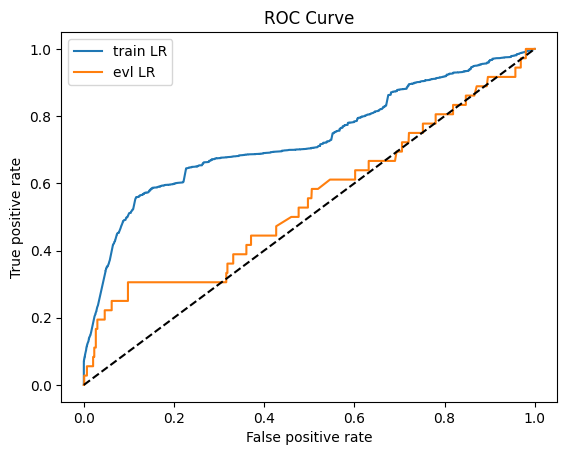

In [13]:
# 使用 Zs 和 label_S 训练模型
lr_model = LogisticRegression(C=0.1, class_weight='balanced', solver='liblinear')
lr_model.fit(Zs.T, label_S)

# 使用 Zt 预测源域数据
y_pred = lr_model.predict_proba(Zs.T)[:, 1]
print(y_pred)
print(type(y_pred))

# 评估模型性能
fpr_lr_train, tpr_lr_train, _ = roc_curve(label_S, y_pred)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ', train_ks)



# 使用 Zt 预测目标域数据
y_pred = lr_model.predict_proba(Zt.T)[:, 1]
print(y_pred)
print(type(y_pred))

# 评估模型性能
fpr_lr, tpr_lr, _ = roc_curve(label_T, y_pred)
val_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ', val_ks)

from matplotlib import pyplot as plt
plt.plot(fpr_lr_train, tpr_lr_train, label = 'train LR')
plt.plot(fpr_lr, tpr_lr, label = 'evl LR')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()

In [14]:
import numpy as np
from scipy import linalg

def DAELM(Train_s, Train_t, Test_t, NL, model_type="CLASSIFIER", num_hidden=100,
          activation="sigmoid", Cs=0.01, Ct=0.01):
    """
    改进版域适应极限学习机 (Domain Adaptation Extreme Learning Machine)

    参数：
    Train_s: 源域训练数据 (n_samples, n_features+1) [最后一列为标签]
    Train_t: 目标域训练数据 (n_samples, n_features+1)
    Test_t: 目标域测试数据 (n_samples, n_features+1)
    NL: 模型选择 (0: 原始DAELM, 1: 正则化形式)
    model_type: 任务类型 ("CLASSIFIER" 或 "REGRESSION")
    num_hidden: 隐层神经元数量
    activation: 激活函数 ("sigmoid", "sin", "relu")
    Cs: 源域正则化参数
    Ct: 目标域正则化参数

    返回：
    预测结果 (分类返回概率矩阵，回归返回预测值)
    """

    # ================= 数据预处理 =================
    # 分离特征和标签
    Train_s = Train_s.to_numpy() if isinstance(Train_s, pd.DataFrame) else Train_s
    Train_t = Train_t.to_numpy() if isinstance(Train_t, pd.DataFrame) else Train_t
    Test_t = Test_t.to_numpy() if isinstance(Test_t, pd.DataFrame) else Test_t


    Xs, ys = Train_s[:, 1:], Train_s[:, 0].astype(int)
    Xt, yt = Train_t[:, 1:], Train_t[:, 0].astype(int)
    X_test, y_test = Test_t[:, 1:], Test_t[:, 0].astype(int)

    # 转置为 (features, samples) 格式
    Xs, Xt, X_test = Xs.T, Xt.T, X_test.T

    # ================= 标签处理 =================
    if model_type == "CLASSIFIER":
        # 获取所有唯一标签
        unique_labels = np.unique(np.concatenate((ys, yt, y_test)))
        num_classes = len(unique_labels)

        # 创建标签映射字典
        label_map = {label: idx for idx, label in enumerate(unique_labels)}

        # 转换标签为one-hot编码
        def to_onehot(labels, num_classes):
            onehot = np.zeros((num_classes, len(labels)))
            for i, label in enumerate(labels):
                onehot[label_map[label], i] = 1
            return onehot * 2 - 1  # 转换为[-1, 1]范围

        Ys = to_onehot(ys, num_classes)
        Yt = to_onehot(yt, num_classes)
        Y_test = to_onehot(y_test, num_classes)
    else:
        Ys = ys.reshape(1, -1)
        Yt = yt.reshape(1, -1)
        Y_test = y_test.reshape(1, -1)

    # ================= 模型初始化 =================
    num_input = Xs.shape[0]

    # He初始化权重
    input_weights = np.random.randn(num_hidden, num_input) * np.sqrt(2. / num_input)
    biases = np.random.randn(num_hidden, 1)

    # ================= 隐层特征计算 =================
    def activate(X, activation_fn):
        """激活函数处理"""
        H = input_weights @ X + biases
        if activation_fn == "sigmoid":
            return 1 / (1 + np.exp(-H))
        elif activation_fn == "sin":
            return np.sin(H)
        elif activation_fn == "relu":
            return np.maximum(0, H)
        else:
            raise ValueError(f"不支持的激活函数: {activation_fn}")

    H_s = activate(Xs, activation)
    H_t = activate(Xt, activation)
    H_test = activate(X_test, activation)

    # ================= 域适应核心计算 =================
    if NL == 0:
        # 原始DAELM公式
        A = H_t @ H_s.T
        B = H_t @ H_t.T + np.eye(H_t.shape[0])/Ct
        C = H_s @ H_t.T
        D = H_s @ H_s.T + np.eye(H_s.shape[0])/Cs

        inv_B = linalg.pinv(B)
        inv_term = linalg.pinv(C @ inv_B @ A - D)

        ApT = inv_B @ Yt - inv_B @ A @ inv_term @ (C @ inv_B @ Yt - Ys)
        ApS = inv_term @ (C @ inv_B @ Yt - Ys)

        output_weights = H_s.T @ ApS + H_t.T @ ApT
    else:
        # 正则化形式
        I = np.eye(num_hidden)
        output_weights = linalg.pinv(
            I + Cs * H_s @ H_s.T + Ct * H_t @ H_t.T
        ) @ (Cs * H_s @ Ys.T + Ct * H_t @ Yt.T)

    # ================= 预测与评估 =================
    predictions = (H_test.T @ output_weights).T

    if model_type == "CLASSIFIER":
        # 转换为概率
        prob = 1 / (1 + np.exp(-predictions))
        return prob.T  # 返回 (n_samples, n_classes)
    else:
        return predictions.T  # 返回 (n_samples, 1)

In [15]:
# 分类任务示例
pred_prob = DAELM(
    trans_S,
    trans_T,
    test,
    NL=1,
    model_type="CLASSIFIER",
    activation="relu",
    num_hidden=200
)

# 获取预测类别
pred_labels = np.argmax(pred_prob, axis=1)

In [16]:
pred_prob

array([[0.73132128],
       [0.73109074],
       [0.73098329],
       ...,
       [0.73098612],
       [0.73102152],
       [0.73097569]])

In [17]:
pred_prob.flatten()
#pred_prob.flatten().tolist()

array([0.73132128, 0.73109074, 0.73098329, ..., 0.73098612, 0.73102152,
       0.73097569])

train_ks :  0.3238400850874266
val_ks :  0.1591082682412432


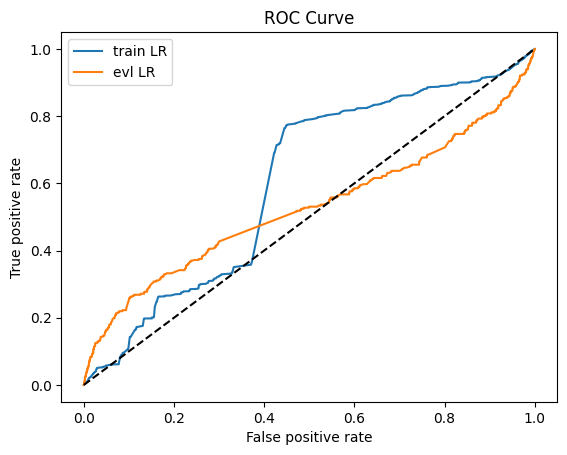

In [18]:
y_pred = DAELM(
    trans_S,
    trans_T,
    trans_data,
    NL=1,
    model_type="CLASSIFIER",
    activation="relu",
    #activation="sigmoid",
    num_hidden=800,
    Cs=0.1,
    Ct=0.1
    #num_hidden=200
)

#y_pred_flat_list = y_pred.flatten().tolist()
#y_pred_flat = y_pred.flatten()
y_pred_flat = 1-y_pred.flatten()

# 评估模型性能
fpr_lr_train, tpr_lr_train, _ = roc_curve(trans_label, y_pred_flat)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ', train_ks)


y_pred = DAELM(
    trans_S,
    trans_T,
    test,
    NL=1,
    model_type="CLASSIFIER",
    activation="relu",
    #activation="sigmoid",
    num_hidden=800,
    Cs=0.1,
    Ct=0.1
    #num_hidden=200
)


#y_pred_flat_list = y_pred.flatten().tolist()
#y_pred_flat = y_pred.flatten()
y_pred_flat = 1-y_pred.flatten()

# 评估模型性能
fpr_lr, tpr_lr, _ = roc_curve(val_y, y_pred_flat)
val_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ', val_ks)

from matplotlib import pyplot as plt
plt.plot(fpr_lr_train, tpr_lr_train, label = 'train LR')
plt.plot(fpr_lr, tpr_lr, label = 'evl LR')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()

---

### 域适应极限学习机（DAELM）数学原理详解

DAELM 是极限学习机（ELM）与域适应（Domain Adaptation）相结合的算法，旨在通过调整隐层特征表示，减少源域和目标域之间的分布差异，提升模型在目标域上的泛化能力。其核心数学原理可分为以下几个部分：

---

#### **1. 标准极限学习机（ELM）回顾**
ELM 是一种单隐层前馈神经网络，其数学形式为：
$$
f(x) = \mathbf{h}(x) \boldsymbol{\beta}
$$
其中：
- $\mathbf{h}(x)$ 是输入 $x$ 的隐层特征映射（通过随机权重和激活函数生成）。
- $\boldsymbol{\beta}$ 是输出层权重矩阵。

训练目标是最小化预测误差：
$$
\min_{\boldsymbol{\beta}} \left\| \mathbf{H} \boldsymbol{\beta} - \mathbf{T} \right\|^2 + \lambda \left\| \boldsymbol{\beta} \right\|^2
$$
解为：
$$
\boldsymbol{\beta} = \left( \mathbf{H}^\top \mathbf{H} + \lambda \mathbf{I} \right)^{-1} \mathbf{H}^\top \mathbf{T}
$$

---

#### **2. 域适应扩展：DAELM的目标函数**
DAELM 在 ELM 的基础上，引入**域适应正则化项**，联合优化源域和目标域的损失。其目标函数为：
$$
\min_{\boldsymbol{\beta}} \underbrace{\left\| \mathbf{H}_s \boldsymbol{\beta} - \mathbf{T}_s \right\|^2}_{\text{源域损失}} + \underbrace{\left\| \mathbf{H}_t \boldsymbol{\beta} - \mathbf{T}_t \right\|^2}_{\text{目标域损失}} + \underbrace{\lambda \left\| \boldsymbol{\beta} \right\|^2}_{\text{正则化}} + \underbrace{\gamma \cdot \text{域差异项}}_{\text{分布对齐}}
$$
其中：
- $\mathbf{H}_s, \mathbf{H}_t$ 为源域和目标域的隐层输出矩阵。
- $\mathbf{T}_s, \mathbf{T}_t$ 为标签矩阵（分类任务为 one-hot 编码）。
- $\lambda, \gamma$ 为超参数。

---

#### **3. 域差异项的构造**
DAELM 通过设计**隐层特征对齐策略**来减小域差异，常见的两种实现方式：

##### **(1) 显式分布对齐（如 MMD）**
使用最大均值差异（MMD）度量源域和目标域隐层特征的分布差异：
$$
\text{MMD}^2 = \left\| \frac{1}{n_s} \sum_{i=1}^{n_s} \mathbf{h}_s^{(i)} - \frac{1}{n_t} \sum_{j=1}^{n_t} \mathbf{h}_t^{(j)} \right\|^2
$$
目标函数中增加 MMD 项：
$$
\gamma \cdot \text{MMD}^2 \rightarrow \gamma \cdot \text{tr}(\boldsymbol{\beta}^\top \mathbf{H}^\top \mathbf{M} \mathbf{H} \boldsymbol{\beta})
$$
其中 $\mathbf{M}$ 是 MMD 矩阵。

##### **(2) 隐式特征加权对齐**
通过调整源域和目标域损失的权重（如代码中的 `Cs` 和 `Ct`），隐式对齐特征分布：
$$
\boldsymbol{\beta} = \arg \min \left( C_s \left\| \mathbf{H}_s \boldsymbol{\beta} - \mathbf{T}_s \right\|^2 + C_t \left\| \mathbf{H}_t \boldsymbol{\beta} - \mathbf{T}_t \right\|^2 + \lambda \left\| \boldsymbol{\beta} \right\|^2 \right)
$$
解为：
$$
\boldsymbol{\beta} = \left( C_s \mathbf{H}_s^\top \mathbf{H}_s + C_t \mathbf{H}_t^\top \mathbf{H}_t + \lambda \mathbf{I} \right)^{-1} \left( C_s \mathbf{H}_s^\top \mathbf{T}_s + C_t \mathbf{H}_t^\top \mathbf{T}_t \right)
$$

---

#### **4. DAELM的两种实现模式**
代码中通过参数 `NL` 选择两种不同的优化策略：

##### **(1) NL=0：原始DAELM公式**
通过显式构建源域和目标域的关系矩阵，求解联合优化问题：
$$
\boldsymbol{\beta} = \mathbf{H}_s^\top \boldsymbol{\alpha}_s + \mathbf{H}_t^\top \boldsymbol{\alpha}_t
$$
其中 $\boldsymbol{\alpha}_s, \boldsymbol{\alpha}_t$ 通过以下线性系统求解：
$$
\begin{cases}
\left( \mathbf{H}_t \mathbf{H}_t^\top + \frac{1}{C_t} \mathbf{I} \right) \boldsymbol{\alpha}_t = \mathbf{T}_t - \mathbf{H}_t \mathbf{H}_s^\top \boldsymbol{\alpha}_s \\
\left( \mathbf{H}_s \mathbf{H}_s^\top + \frac{1}{C_s} \mathbf{I} \right) \boldsymbol{\alpha}_s = \mathbf{T}_s - \mathbf{H}_s \mathbf{H}_t^\top \boldsymbol{\alpha}_t
\end{cases}
$$

##### **(2) NL=1：正则化形式**
直接通过加权正则化最小二乘求解：
$$
\boldsymbol{\beta} = \left( \mathbf{I} + C_s \mathbf{H}_s \mathbf{H}_s^\top + C_t \mathbf{H}_t \mathbf{H}_t^\top \right)^{-1} \left( C_s \mathbf{H}_s \mathbf{T}_s^\top + C_t \mathbf{H}_t \mathbf{T}_t^\top \right)
$$

---

#### **5. 算法流程**
1. **隐层随机初始化**：随机生成输入权重 $\mathbf{W}$ 和偏置 $\mathbf{b}$。
2. **隐层特征映射**：计算源域和目标域的隐层输出：
   $$
   \mathbf{H}_s = \sigma(\mathbf{W} \mathbf{X}_s + \mathbf{b}), \quad \mathbf{H}_t = \sigma(\mathbf{W} \mathbf{X}_t + \mathbf{b})
   $$
3. **求解输出权重**：根据选择的模式（NL=0 或 NL=1）计算 $\boldsymbol{\beta}$。
4. **预测目标域数据**：使用 $\boldsymbol{\beta}$ 预测目标域测试集：
   $$
   \hat{\mathbf{T}}_{\text{test}} = \mathbf{H}_{\text{test}} \boldsymbol{\beta}
   $$

---

#### **6. 数学特性对比**
| 模式    | 优点                      | 缺点                  |
|---------|--------------------------|-----------------------|
| NL=0    | 显式建模域关系，理论完备   | 计算复杂，矩阵逆不稳定 |
| NL=1    | 计算高效，数值稳定         | 隐式对齐，理论解释弱  |

---

#### **7. 实际应用中的改进**
- **激活函数选择**：ReLU 提升非线性表达能力。
- **He初始化**：改进隐层权重初始化，避免梯度消失。
- **标签对齐**：通过 one-hot 编码和标签映射处理类别偏移。
- **正则化增强**：防止过拟合，提升泛化性能。

通过上述数学框架，DAELM 能够有效减小域间分布差异，在跨域分类和回归任务中表现出色。